# Result Prediction

In [50]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier

import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
X, y = pd.read_csv('WL_Model/WL_train.csv'), pd.read_csv('Train_Data/Y_train.csv', index_col=0)
y = y.loc[X.index] # This is our target

We will encode the y set, so that 

- -1: Loss
- 0: Draw
- 1: Win

In [3]:
mappings = {'AWAY_WINS' : -1, 'DRAW' : 0, 'HOME_WINS' : 1}
y = pd.from_dummies(y)[''].apply(lambda x : mappings[x])
y.head()

y = pd.DataFrame(y)
y.columns = ['RESULT']
y['RESULT']=y['RESULT'].astype('int')
y.head()

,RESULT
0,-1
1,0
2,-1
3,1
4,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 48) # This random state means that we use the same test/train/valid set as GD prediction
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 48)

## Feature Selection

So, we now need to select the feature upon which we will train our model. At the moment, I am unsure what the best approach will be: do we predict WDL or just WL? I will therefore apply stepwise selection of both sets of data to figure out which are the best features to use (hopefully there will be some overlap). 

Before we do that, however, we will play the same trick as before: we create an upsampled data set.

In [5]:
y_train['RESULT'].value_counts()

RESULT
 1    3409
-1    2387
 0    2077
Name: count, dtype: int64

As we will want to predict WL and WLD, we will create seperate training sets. 

In [6]:
X_train_WL = X_train.loc[y_train['RESULT'] != 0]
y_train_WL = y_train.loc[y_train['RESULT'] != 0]
display(X_train_WL.describe())
display(y_train_WL.describe())

,HOME_TEAM_INJURIES_season_sum,HOME_TEAM_GAME_WON_season_sum,HOME_TEAM_GAME_DRAW_season_sum,HOME_TEAM_GAME_LOST_season_sum,HOME_TEAM_SHOTS_TOTAL_season_std,HOME_TEAM_SHOTS_INSIDEBOX_season_std,HOME_TEAM_SHOTS_OFF_TARGET_season_std,HOME_TEAM_SHOTS_ON_TARGET_season_std,HOME_TEAM_SHOTS_OUTSIDEBOX_season_std,HOME_TEAM_PASSES_season_std,...,DIFF_TEAM_GAME_LOST_5_last_match_sum,DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,DIFF_TEAM_BALL_POSSESSION_5_last_match_average,WIN_PRIOR,DRAW_PRIOR,LOST_PRIOR,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum,DIFF_FORM_5_last_match_sum,NORMAL_SAMPLED_PREDICTED_GD
count,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,...,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000
mean,4.131203,4.228283,4.544569,4.646764,4.231871,4.161379,4.047964,3.902519,3.925650,4.167007,...,5.040966,4.988469,4.960202,1.142156,1.036506,1.128329,5.013516,4.977776,5.121805,4.618316
std,2.687886,2.904821,2.900582,2.932404,2.787886,2.617733,2.803999,2.764558,2.617348,2.649725,...,2.079329,1.869084,1.943016,1.250944,0.915414,1.211432,1.302311,1.277886,1.359175,1.650598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486883,0.491021,0.000000,0.159426
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.500000,4.000000,3.500000,0.227273,0.303030,0.226244,4.177035,4.124212,4.248436,3.513435
50%,4.153921,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.899202,4.000000,...,5.000000,4.962532,5.000000,0.769231,0.857143,0.769231,5.013790,4.961663,5.131535,4.602158
75%,6.000000,6.000000,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,...,6.500000,6.000000,6.500000,1.666667,1.587302,1.666667,5.859366,5.775320,6.006427,5.722243
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,6.944444,9.000000,9.032123,9.033172,9.264531,10.000000


,RESULT
count,5796.000000
mean,0.176329
std,0.984416
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


### Feature Selection with Wins & Losses

In [7]:
def stepwise_selection(p, model, X_train, y_train):
    '''Uses backwards selection to select the p best features'''
    selector = RFE(model, n_features_to_select=1)
    selector = selector.fit(X_train, y_train)
    
    lst = [(r, c) for r, c in zip(selector.ranking_, X_train.columns)]
    lst.sort(key = lambda x : x[0])
    
    return [x[1] for x in lst[:p]], selector.estimator_

In [8]:
def stepwise_selection_plotting(features, X_train, y_train, X_valid, y_valid, measure = accuracy_score, train_score_weight = 0.74):
    train_score, valid_score = [], []
    for p in range(len(features)):
        model = RidgeClassifier()
        model.fit(X_train[features[:p+1]], y_train)

        train_score.append(train_score_weight*measure(y_train, model.predict(X_train[features[:p+1]])))
        valid_score.append(measure(y_valid, model.predict(X_valid[features[:p+1]])))

    x = [f'{f}, {i}' for i, f in enumerate(features)]
    plt.plot(x, train_score, label = 'Training Score')
    plt.plot(x, valid_score, label = 'Validation Score')
    plt.ylabel('Score')    
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

Using these two functions we will obtain the most relevant features using a simiple linear classifier

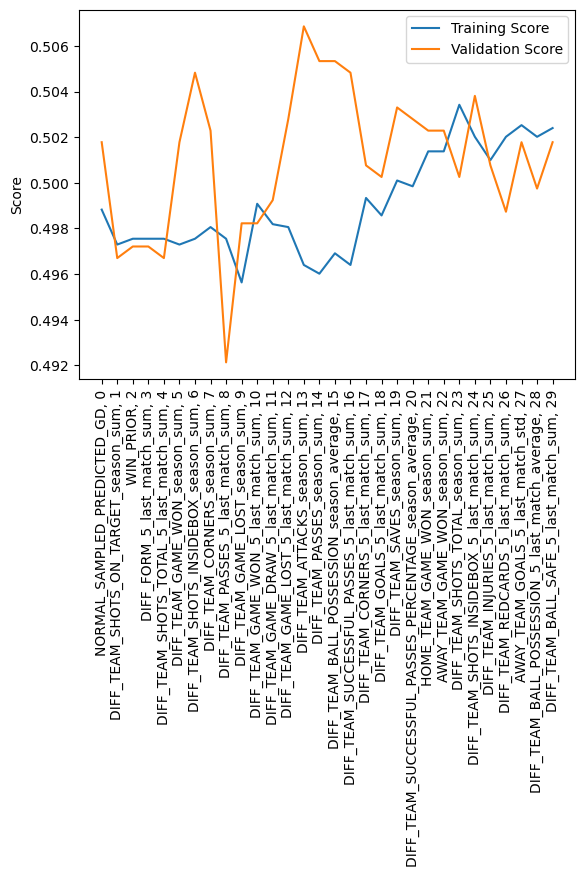

In [9]:
best_features_WL, _ = stepwise_selection(30, RidgeClassifier(), X_train_WL, y_train_WL)
stepwise_selection_plotting(best_features_WL, X_train_WL, y_train_WL, X_valid, y_valid)
# best_features_WL = pd.read_csv('goal_diff_prediction/Features.csv')['Feature'].to_list() + ['NORMAL_SAMPLED_PREDICTED_GD'] 

In [10]:
print("Selected Features\n-----------------\n")
print(*best_features_WL[:25], sep = '\n') 
selected_features = list(best_features_WL[:25])

Selected Features
-----------------

NORMAL_SAMPLED_PREDICTED_GD
DIFF_TEAM_SHOTS_ON_TARGET_season_sum
WIN_PRIOR
DIFF_FORM_5_last_match_sum
DIFF_TEAM_SHOTS_TOTAL_5_last_match_sum
DIFF_TEAM_GAME_WON_season_sum
DIFF_TEAM_SHOTS_INSIDEBOX_season_sum
DIFF_TEAM_CORNERS_season_sum
DIFF_TEAM_PASSES_5_last_match_sum
DIFF_TEAM_GAME_LOST_season_sum
DIFF_TEAM_GAME_WON_5_last_match_sum
DIFF_TEAM_GAME_DRAW_5_last_match_sum
DIFF_TEAM_GAME_LOST_5_last_match_sum
DIFF_TEAM_ATTACKS_season_sum
DIFF_TEAM_PASSES_season_sum
DIFF_TEAM_BALL_POSSESSION_season_average
DIFF_TEAM_SUCCESSFUL_PASSES_5_last_match_sum
DIFF_TEAM_CORNERS_5_last_match_sum
DIFF_TEAM_GOALS_5_last_match_sum
DIFF_TEAM_SAVES_season_sum
DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average
HOME_TEAM_GAME_WON_season_sum
AWAY_TEAM_GAME_WON_season_sum
DIFF_TEAM_SHOTS_TOTAL_season_sum
DIFF_TEAM_SHOTS_INSIDEBOX_5_last_match_sum


So here we have our 20 selected features. This model seems to be doing rather well. In particular
- The predicted GD is doing very well at helping to make the correct estimation
- The season sum of goals doesn't appear, however I imagine this is because of the GD doing a lot of the work for this statistic.
- Oh, and the diff statistics seem to capture the information well enough. 

## Model Fitting 

We will start by just predicting a Win (W) loss (L) model, before doing a WLD model. We will find that both models perform similarly, so we will stay with WL. 

### WL Fitting

In [11]:
# Some function that does the fitting 
def fit_WL_classifier(model_type, model_params = None, analytics = False, up_sampled = False):
    ''' Fits a model to the data give with the model_params. Then prints analytics so we get an idea of the model'''
    X, y =  (X_train_upsampled_WL[selected_features], y_train_upsampled_WL) if up_sampled else (X_train_WL[selected_features], y_train_WL)
    
    model_params = {} if model_params is None else model_params
    
    model = model_type(**model_params)
    model.fit(X, y)

    if analytics:
        print("Test Result\n----------")
        show_classification_metrics(y['RESULT'], model.predict(X[selected_features]),0.75)
        print("Validation Result\n-------------")
        show_classification_metrics(y_valid['RESULT'], model.predict(X_valid[selected_features]))
        
    return model

In [12]:
# Some function that prints the classification metrics
def show_classification_metrics(y_true, y_pred, multi = 1):
    print("Accuracy: " , np.round(multi*accuracy_score(y_true, y_pred),4))
    print("Weighted F1: ", np.round(f1_score(y_true, y_pred, average = 'weighted'),4))
    print(confusion_matrix(y_true, y_pred))

In [13]:
def find_WL_hyperparams(estimator, param_grid, up_sampled):
    '''Grid Searches for the best hyper params using CV, then return the best model fitting on the data'''
    X, y =  (X_train_upsampled_WL[selected_features], y_train_upsampled_WL) if up_sampled else (X_train_WL[selected_features], y_train_WL)
    
    clf = GridSearchCV(estimator = estimator(), param_grid=param_grid, verbose = 1)
    clf.fit(X, y)
    return clf.best_params_

#### Linear Ridge Classifier

In [14]:
RC_norm_WL_best_param = find_WL_hyperparams(RidgeClassifier, {'alpha' : np.linspace(1, 27)}, False)
print(RC_norm_WL_best_param)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'alpha': 24.346938775510207}


In [15]:
print("\nNormal Sampled\n-------------")
RC_norm_WL = fit_WL_classifier(RidgeClassifier, RC_norm_WL_best_param, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5094
Weighted F1:  0.671
[[1196 1191]
 [ 668 2741]]
Validation Result
-------------
Accuracy:  0.5023
Weighted F1:  0.425
[[292   0 306]
 [149   0 343]
 [182   0 697]]


#### LDA

In [16]:
print("\nNormal Sampled\n-------------")
LDA_norm_WL = fit_WL_classifier(LinearDiscriminantAnalysis, {}, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5084
Weighted F1:  0.6703
[[1210 1177]
 [ 690 2719]]
Validation Result
-------------
Accuracy:  0.5023
Weighted F1:  0.4253
[[295   0 303]
 [151   0 341]
 [185   0 694]]


#### Logistic Regression

In [17]:
LRC_norm_WL_best_param = find_WL_hyperparams(LogisticRegression, {'penalty' : ['l2'], 'C' : np.linspace(12, 14, 20)}, False)
print(LRC_norm_WL_best_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 12.947368421052632, 'penalty': 'l2'}


In [18]:
print("\nNormal Sampled\n-------------")
LRC_norm_WL = fit_WL_classifier(LogisticRegression, LRC_norm_WL_best_param, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5092
Weighted F1:  0.6717
[[1220 1167]
 [ 694 2715]]
Validation Result
-------------
Accuracy:  0.5063
Weighted F1:  0.4285
[[295   0 303]
 [156   0 336]
 [177   0 702]]


#### QDA

QDA is rubbish so I removed it

#### KNN

In [19]:
KNN_norm_WL_best_param = find_WL_hyperparams(KNeighborsClassifier, {'n_neighbors' : range(145,155,1),
                                                                   'weights' : ['uniform']}, False)
print(KNN_norm_WL_best_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 149, 'weights': 'uniform'}


In [20]:
print("\nNormal Sampled\n-------------")
KNN_norm_WL = fit_WL_classifier(KNeighborsClassifier, KNN_norm_WL_best_param, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5026
Weighted F1:  0.6545
[[1035 1352]
 [ 560 2849]]
Validation Result
-------------
Accuracy:  0.5063
Weighted F1:  0.4237
[[259   0 339]
 [122   0 370]
 [141   0 738]]


#### Random Forest

I can't stop this from overfitting --> DONT USE

In [21]:
RFC_norm_WL_best_param = find_WL_hyperparams(RandomForestClassifier, 
                                             {'n_estimators' : [195], 
                                            'min_samples_split' :[11],
                                              'max_depth' : [1],
                                              'max_features' : ['sqrt']}
                                             , False)
RFC_norm_WL_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_split': 11,
 'n_estimators': 195}

In [22]:
print("\nNormal Sampled\n-------------")
RFC_norm_WL = fit_WL_classifier(RandomForestClassifier, {}, analytics = True, up_sampled = False);


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.75
Weighted F1:  1.0
[[2387    0]
 [   0 3409]]
Validation Result
-------------
Accuracy:  0.4881
Weighted F1:  0.4117
[[273   0 325]
 [141   0 351]
 [191   0 688]]


#### AdaBoost 

In [23]:
ABC_norm_WL_best_param = find_WL_hyperparams(AdaBoostClassifier, {'n_estimators' : range(10,20, 1)}, False)
ABC_norm_WL_best_param

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 11}

In [24]:
print("\nNormal Sampled\n-------------")
ABC_norm_WL = fit_WL_classifier(AdaBoostClassifier, ABC_norm_WL_best_param, analytics = True, up_sampled = False);


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5063
Weighted F1:  0.6643
[[1134 1253]
 [ 630 2779]]
Validation Result
-------------
Accuracy:  0.5003
Weighted F1:  0.4208
[[271   0 327]
 [139   0 353]
 [165   0 714]]


#### Bagging

Can't get it to stop overfitting -> don't use

#### Gradient Boosting

In [25]:
GBC_norm_WL_best_param = find_WL_hyperparams(GradientBoostingClassifier, 
                                             {'n_estimators' : range(10, 20),
                                                'criterion' : ['squared_error'],
                                             'learning_rate' : [0.095],
                                             'subsample' : [1]}, False)
GBC_norm_WL_best_param

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'criterion': 'squared_error',
 'learning_rate': 0.095,
 'n_estimators': 19,
 'subsample': 1}

In [26]:
print("\nNormal Sampled\n-------------")
GBC_norm_WL = fit_WL_classifier(GradientBoostingClassifier, GBC_norm_WL_best_param, analytics = True, up_sampled = False);


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5096
Weighted F1:  0.6674
[[1119 1268]
 [ 590 2819]]
Validation Result
-------------
Accuracy:  0.4977
Weighted F1:  0.4176
[[262   0 336]
 [136   0 356]
 [161   0 718]]


#### NN Classifier

In [27]:
NNC_norm_WL_best_param = find_WL_hyperparams(MLPClassifier, {'hidden_layer_sizes' : [(100)],
                                                             'activation' : ['tanh'], 'early_stopping' :[True]}, False)
NNC_norm_WL_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': 100}

In [28]:
print("\nNormal Sampled\n-------------")
NNC_norm_WL = fit_WL_classifier(MLPClassifier, NNC_norm_WL_best_param, analytics = True, up_sampled = False);


Normal Sampled
-------------
Test Result
----------
Accuracy:  0.5047
Weighted F1:  0.6643
[[1176 1211]
 [ 685 2724]]
Validation Result
-------------
Accuracy:  0.4962
Weighted F1:  0.4191
[[282   0 316]
 [152   0 340]
 [184   0 695]]


#### Best WL Classifiers

Interestingly, the linear classifiers are doing really well.  Having said that all, apart from the NN are beating the top score in their own right, so lets put them all togther. 

In [46]:
WL_voting_clf = VotingClassifier(estimators = [
                                 ('NNC', NNC_norm_WL), 
                                 ('GBC', GBC_norm_WL),
                                 ('ABC', ABC_norm_WL),
                                 ('KNN', KNN_norm_WL),
                                 ('LRC', LRC_norm_WL), 
                                 ('LDA', LDA_norm_WL),
                                 # ('RC', RC_norm_WL) # We have to ignore this as we are using voting = 'soft'
                                ],
                                voting = 'soft')
WL_voting_clf.fit(X_train_WL[selected_features], y_train_WL)  
show_classification_metrics(y_train_WL['RESULT'], WL_voting_clf.predict(X_train_WL[selected_features]),0.75)
show_classification_metrics(y_valid['RESULT'], WL_voting_clf.predict(X_valid[selected_features]))
                                 
                                 

Accuracy:  0.5107
Weighted F1:  0.6696
[[1134 1253]
 [ 596 2813]]
Accuracy:  0.4987
Weighted F1:  0.4192
[[268   0 330]
 [140   0 352]
 [165   0 714]]


So this classifier seems to be working rather well! Now lets try and predict WDL

### WDL Classification 

In [51]:
def fit_WLD_classifier(model_type, model_params = None, OvR = True):
    ''' Fits a model to the data give with the model_params. Then prints analytics so we get an idea of the model'''
    X, y =  (X_train[selected_features], y_train)
    
    model_params = {} if model_params is None else model_params
    
    model = OneVsRestClassifier(model_type(**model_params)) if OvR else OneVsOneClassifier(model_type(**model_params))
    model.fit(X, y)

   
    show_classification_metrics(y['RESULT'], model.predict(X[selected_features]))
    show_classification_metrics(y_valid['RESULT'], model.predict(X_valid[selected_features]))
        
    return model

In [52]:
def get_classifier_dict(grid_search_dict): # This will remove the estimator__ predix
    return {k[11:] : v for k, v in grid_search_dict.items()}

In [53]:
def find_WLD_hyperparams(estimator, param_grid):
    '''Grid Searches for the best hyper params using CV, then return the best model fitting on the data'''
    X, y =  (X_train[selected_features], y_train)
    
    clf = GridSearchCV(estimator = OneVsRestClassifier(estimator()), param_grid=param_grid, verbose = 1)
    clf.fit(X, y)
    return get_classifier_dict(clf.best_params_)

#### Ridge Classifier

In [54]:
RC_norm_WLD_best_param = find_WLD_hyperparams(RidgeClassifier, {'estimator__alpha' : np.linspace(1,1.7,20)})
print(RC_norm_WLD_best_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'alpha': 1.0}


In [55]:
print("\nNormal Sampled\n-------------")
RC_norm_WLD = fit_WLD_classifier(RidgeClassifier, RC_norm_WLD_best_param); 


Normal Sampled
-------------
Accuracy:  0.4979
Weighted F1:  0.4181
[[1210    1 1176]
 [ 703    3 1371]
 [ 702    0 2707]]
Accuracy:  0.5013
Weighted F1:  0.4245
[[294   0 304]
 [153   0 339]
 [185   1 693]]


#### LDA

In [56]:
print("\nNormal Sampled\n-------------")
LDA_norm_WLD = fit_WLD_classifier(LinearDiscriminantAnalysis, {});


Normal Sampled
-------------
Accuracy:  0.498
Weighted F1:  0.4196
[[1210    5 1172]
 [ 702    9 1366]
 [ 699    8 2702]]
Accuracy:  0.5013
Weighted F1:  0.4257
[[295   2 301]
 [153   1 338]
 [186   2 691]]


#### KNN

In [57]:
KNN_norm_WLD_best_param = find_WLD_hyperparams(KNeighborsClassifier, {'estimator__n_neighbors' : range(60,70, 1)})
print(KNN_norm_WLD_best_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 67}


In [58]:
print("\nNormal Sampled\n-------------")
KNN_norm_WLD = fit_WLD_classifier(KNeighborsClassifier, KNN_norm_WLD_best_param); 


Normal Sampled
-------------
Accuracy:  0.5004
Weighted F1:  0.4494
[[1011  160 1216]
 [ 524  198 1355]
 [ 544  134 2731]]
Accuracy:  0.5018
Weighted F1:  0.4482
[[232  47 319]
 [108  40 344]
 [124  39 716]]


#### Adaboost 

In [59]:
ABC_norm_WLD_best_param = find_WLD_hyperparams(AdaBoostClassifier, {'estimator__n_estimators' : range(0,6)})
print(ABC_norm_WLD_best_param)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'n_estimators': 4}


In [60]:
print("\nNormal Sampled\n-------------")
ABC_norm_WLD = fit_WLD_classifier(AdaBoostClassifier, ABC_norm_WLD_best_param); 


Normal Sampled
-------------
Accuracy:  0.4963
Weighted F1:  0.4172
[[1054   17 1316]
 [ 581   26 1470]
 [ 563   19 2827]]
Accuracy:  0.4962
Weighted F1:  0.4207
[[256   7 335]
 [120   4 368]
 [150  12 717]]


#### Gradient Boosting

In [61]:
GBC_norm_WLD_best_param = find_WLD_hyperparams(GradientBoostingClassifier, {'estimator__n_estimators' : range(35,40, 1)})
print(GBC_norm_WLD_best_param)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_estimators': 39}


In [62]:
print("\nNormal Sampled\n-------------")
GBC_norm_WLD = fit_WLD_classifier(GradientBoostingClassifier, GBC_norm_WLD_best_param);


Normal Sampled
-------------
Accuracy:  0.5173
Weighted F1:  0.4499
[[1151   21 1215]
 [ 591  105 1381]
 [ 571   21 2817]]
Accuracy:  0.5018
Weighted F1:  0.4288
[[269   7 322]
 [132   6 354]
 [149  17 713]]


#### NN 

In [63]:
NNC_norm_WLD_best_param = find_WLD_hyperparams(MLPClassifier, {'estimator__hidden_layer_sizes' : [(100)],
                                                             'estimator__activation' : ['logistic'], 'estimator__early_stopping' :[True]})
NNC_norm_WLD_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': 100}

In [64]:
NNC_norm_WLD = fit_WLD_classifier(MLPClassifier, NNC_norm_WLD_best_param);

Accuracy:  0.4954
Weighted F1:  0.4153
[[1192    0 1195]
 [ 708    1 1368]
 [ 700    2 2707]]
Accuracy:  0.5043
Weighted F1:  0.4267
[[293   0 305]
 [152   0 340]
 [179   0 700]]


#### WLD Conclusions

There seems to be no real improvement over using the WL classifier, therefore we will only use that. 

## Testing and Saving WL Classifier

To check that we haven't done any silly overfitting, we can print the scores on each of the training, validation and test data set.

In [47]:
print("Training Scores\n---------------")
show_classification_metrics(y_train_WL['RESULT'], WL_voting_clf.predict(X_train_WL[selected_features]),0.75)

print("\nValidation Scores\n-----------------")
show_classification_metrics(y_valid['RESULT'], WL_voting_clf.predict(X_valid[selected_features]))

print("\nTesting Scores\n--------------")
show_classification_metrics(y_test['RESULT'], WL_voting_clf.predict(X_test[selected_features]))

Training Scores
---------------
Accuracy:  0.5107
Weighted F1:  0.6696
[[1134 1253]
 [ 596 2813]]

Validation Scores
-----------------
Accuracy:  0.4987
Weighted F1:  0.4192
[[268   0 330]
 [140   0 352]
 [165   0 714]]

Testing Scores
--------------
Accuracy:  0.497
Weighted F1:  0.4183
[[360   0 416]
 [186   0 431]
 [205   0 863]]


i.e. we seem to be doing pretty well! I guess we should now go ahead and train this model

In [48]:
with open('WL_Model/WL_prediction.pkl', 'wb') as f:
    pickle.dump(WL_voting_clf, f)

In [49]:
features = pd.DataFrame({'Feature' : selected_features})
features.to_csv("WL_Model/WL_model_features.csv")